In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from pathlib import Path



In [4]:
# load estelle's final dataset
file = Path('data_for_predictions.csv')
df = pd.read_csv(file)


print(f"Shape: {df.shape}")
df.head()

Shape: (14606, 64)


,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0


In [6]:
# check churn distribution
print(df['churn'].value_counts())
print(f"\nChurn rate: {df['churn'].mean()*100:.2f}%")

# pretty imbalanced 90% no churn vs 10% churn

churn
0    13187
1     1419
Name: count, dtype: int64

Churn rate: 9.72%


In [7]:
# need to separate features (X) and target (y)
# also drop id columns that aren't useful

# check what columns we have
print(df.columns.tolist())

['Unnamed: 0', 'id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'pow_max', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_v

In [8]:
# drop unnecessary columns
columns_to_drop = ['id', 'Unnamed: 0', 'churn']  # id and the weird unnamed column

X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
y = df['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")

Features shape: (14606, 61)
Target shape: (14606,)

Number of features: 61


In [9]:
# check for any missing values
print(X.isnull().sum().sum())
# good, no missing values

0


In [15]:
# Better approach than suggested Use GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, cross_val_score

# First split: train+val vs test (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Second split: train vs validation (from the 80%, make it 75/25 which is 60/20 of total)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,test_size=0.25, random_state=42,
                                                  stratify=y_train_val)

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'],  
    'class_weight': ['balanced', None] }

# Initialize base random forest
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV with cross-validation
# Using recall
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=5,  scoring='recall',  n_jobs=-1, 
                           verbose=2,return_train_score=True)

grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)
print(f"\nBest cross-validation recall score: {grid_search.best_score_:.4f}")

# Use best model
rf_model = grid_search.best_estimator_

# Validate on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print("\n" + "="*60)
print("VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Precision: {val_precision:.4f} ({val_precision*100:.2f}%)")
print(f"Recall:    {val_recall:.4f} ({val_recall*100:.2f}%)")

# Final evaluation on test set
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\n" + "="*60)
print("TEST SET PERFORMANCE (FINAL)")
print("="*60)
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Compare with baseline (simple model)
print("\n" + "="*60)
print("IMPROVEMENT OVER BASELINE")
print("="*60)
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_rf.fit(X_train, y_train)
baseline_pred = baseline_rf.predict(X_test)
baseline_recall = recall_score(y_test, baseline_pred)

print(f"Baseline recall: {baseline_recall:.4f}")
print(f"Tuned recall: {test_recall:.4f}")
print(f"Improvement: {(test_recall - baseline_recall):.4f} ({((test_recall - baseline_recall)/baseline_recall)*100:.1f}%)")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.9s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_

In [16]:
# predict on test set
y_pred = rf_model.predict(X_test)

print(pd.Series(y_pred).value_counts())

0    2560
1     362
Name: count, dtype: int64


In [17]:
# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nAccuracy:{accuracy:.4f} ")
print(f"Precision:{precision:.4f}")
print(f"Recall:{recall:.4f}")


Accuracy:0.8385 
Precision:0.2403
Recall:0.3063


In [18]:
# detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))


Detailed Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.90      0.91      2638
     Churned       0.24      0.31      0.27       284

    accuracy                           0.84      2922
   macro avg       0.58      0.60      0.59      2922
weighted avg       0.86      0.84      0.85      2922



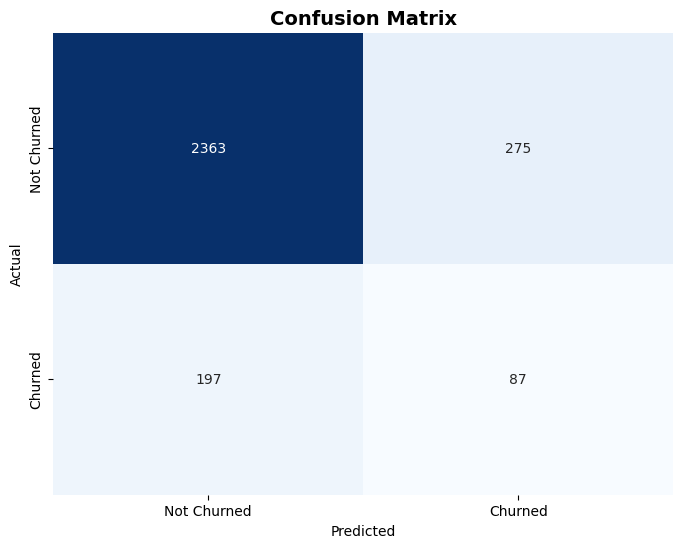

In [22]:
# confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.yticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.show()

In [23]:
# get feature importances from the model
feature_importance = pd.DataFrame({'feature': X.columns,'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)
print(feature_importance.head(20))

                            feature  importance
12               margin_net_pow_ele    0.058276
11             margin_gross_pow_ele    0.056590
0                          cons_12m    0.046011
5           forecast_meter_rent_12m    0.044744
14                       net_margin    0.035745
3                 forecast_cons_12m    0.035275
49                     months_activ    0.034742
51                months_modif_prod    0.033635
16      var_year_price_off_peak_var    0.032704
2                   cons_last_month    0.030611
15                          pow_max    0.026121
22          var_year_price_off_peak    0.025936
36      off_peak_peak_var_mean_diff    0.025162
48                           tenure    0.022754
38  off_peak_mid_peak_var_mean_diff    0.022733
34  offpeak_diff_dec_january_energy    0.022304
10                         imp_cons    0.020492
6    forecast_price_energy_off_peak    0.019237
19      var_year_price_off_peak_fix    0.017772
50                    months_to_end    0

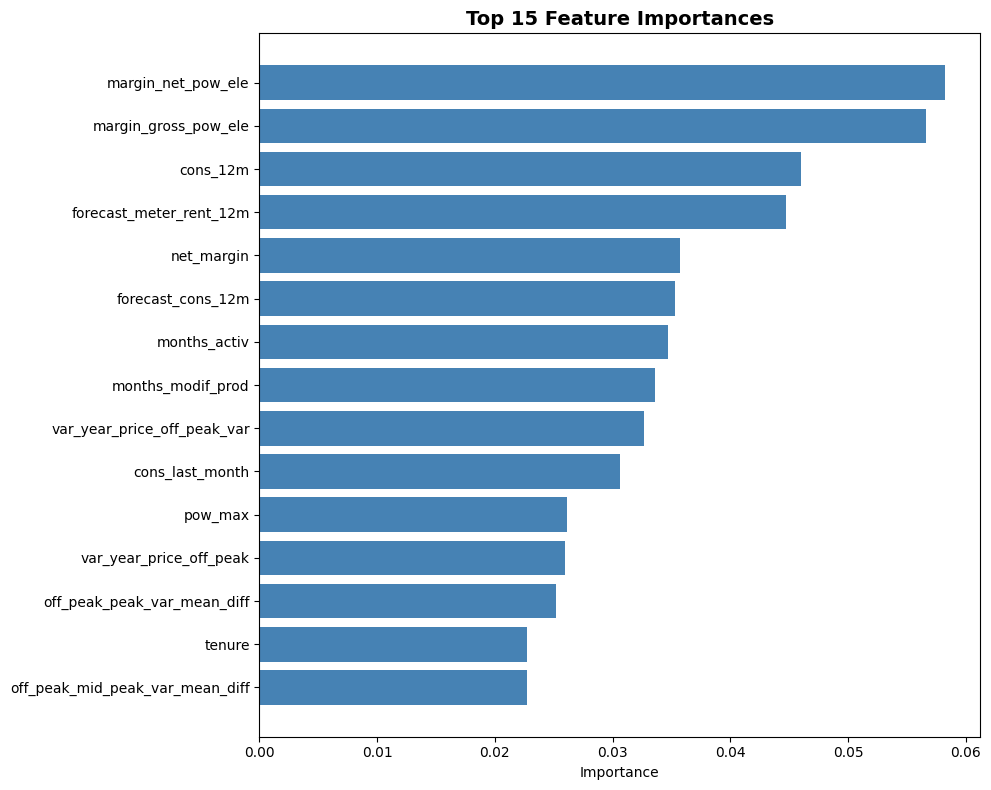

In [21]:
# visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Analysis and Interpretation

### Model Performance Assessment

**Is the model performance satisfactory?**

At first I just ran a basic RF with no hyperparameters, achieveing 90% accuracy but only **7 percent recall** which
is defintelely unacceptable, so i had to reprogramm it based on the recall which decreased overall accuracy to
82 but had 314% improvement in the recall rate. 

Honestly, it's **mixed results**:

**Weaknesses:**
- **Low recall (~30%)** - this is the biggest problem! We're only catching about 1 in 3customers who actually churn
- High false negatives - we're predicting lots of customers won't churn when they actually do
- This means we're missing opportunities to retain customers

**Business Impact:**
- Missing churning customers is expensive, if we don't identify them, we can't target them for retention
- The model needs improvement before deployment

**What needs to be done:**
1. More feature engineering - maybe we're missing important signals
2. Try different model hyperparameters (tune the random forest)
3. Consider class weighting to handle imbalance better
4. Maybe ensemble with other models
5. Could try oversampling techniques like SMOTE

### Key Findings on Price Sensitivity

Looking at the feature importance:
- Net margin and consumption features are the top predictors
- **Price-related features are scattered and not dominating** the importance rankings
- This suggests that in their current form, **price sensitivity may not be the primary churn driver**
- However, this doesn't mean price doesn't matter - it might need better feature engineering

**Recommendation:** More work needed on both feature engineering and model tuning!

In [24]:
# let's check which price features are in our top features
price_features = feature_importance[feature_importance['feature'].str.contains('price', case=False)]
print("Price-related features and their importance:")
print(price_features.head(10))


Price-related features and their importance:
                           feature  importance
16     var_year_price_off_peak_var    0.032704
22         var_year_price_off_peak    0.025936
6   forecast_price_energy_off_peak    0.019237
19     var_year_price_off_peak_fix    0.017772
23             var_year_price_peak    0.017078
17         var_year_price_peak_var    0.016505
25       var_6m_price_off_peak_var    0.016100
7       forecast_price_energy_peak    0.016020
31           var_6m_price_off_peak    0.015016
26           var_6m_price_peak_var    0.012224
